In [ ]:
#@title Mount Google Drive
import os
from google.colab import drive
drive.mount('/content/gdrive')

# mount the shared drive and cd to DeepOnet-Cylinder
DRIVE_PATH = '/content/gdrive/Shareddrives/DeepONet_iSahin/Bifidelity-Cylinder-CFD/DeepOnet-Cylinder'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
%cd $DRIVE_PATH

Mounted at /content/gdrive
/content/gdrive/Shareddrives/DeepONet_iSahin/Bifidelity-Cylinder-CFD/DeepOnet-Cylinder


In [ ]:
###################### Configs #########################
class dotdict(dict):
    """dot.notation access to dictionary attributes."""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
args = dotdict()  

# LF-> low fidelity,
# HF-> high fidelity   
## general args
seed = 1234

args.verbose=True # help="printing during training"
args.scale_mode="min-max" # help="normalize or min-max"

## DeepONet args
args.LF_branch_type = "MLP" # help="modified, MLP or FF-MLP "
args.HF_branch_type = "MLP" # help="modified, MLP or FF-MLP " 
args.nSensors=1 # help="number of design points"
args.LF_trunk_type="MLP" # help="modified, MLP or FF-MLP "
args.HF_trunk_type="MLP" # help="modified, MLP or FF-MLP "  
args.width = 100 # help="width of nns"
args.depth = 1 # help="depth of nns"
args.nBasis = 100 # help="number of basis"
args.activation = "relu" # help="leaky, silu, Rrelu, Mish, sin, relu, tanh, selu, rsin, or gelu"
args.deeponet_type = "vanilla" # help="vanilla or modified"
args.nLocs = 500 # help="number of sampling locations"
args.LF_nmode = 50 # help="number of mode in FF_mlp locations"
args.HF_nmode = 50 # help="number of mode in FF_mlp locations"

## training args
args.learning_rate = 5e-3 # help="learning rate"
args.batch_size = 256 # help="training batch size"
args.nEpochs = 1000 # help="number of training epochs"
args.loss = "MSE" # help="MAE or MSE"
args.monitor = "train-loss" # help="train-loss or val-loss"
args.rng = 456 # help="random state"

# General
args.field='lift' # lift or drag
args.method= 'Physics' # Physics or Data
args.cutting=False

Using GPU id 0
Shapes for LF DeepONet training u=(60500, 1), y=(60500, 1), G=(60500, 1)
Physics_DeepONet(
  (model_A): DeepONet(
    (branch): MLP(
      (net): ModuleList(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): ReLU()
        (2): Linear(in_features=100, out_features=100, bias=True)
      )
    )
    (trunk): MLP(
      (net): ModuleList(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): ReLU()
        (2): Linear(in_features=100, out_features=100, bias=True)
      )
    )
  )
  (model_B): DeepONet(
    (branch): MLP(
      (net): ModuleList(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): ReLU()
        (2): Linear(in_features=100, out_features=100, bias=True)
      )
    )
    (trunk): MLP(
      (net): ModuleList(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): ReLU()
        (2): Linear(in_features=100, out_features=100, bias=True)
      )
    )
  )
)

***** T

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00489: reducing learning rate of group 0 to 4.5000e-03.
Epoch 00745: reducing learning rate of group 0 to 4.0500e-03.
Epoch 00971: reducing learning rate of group 0 to 3.6450e-03.
31
Shapes of test data u=(31,), y=(31, 4557), G=(31, 4557)

==== low fidelity stats ====

     L1-relative Error %      
     mean     st. dev.  
-----------------------------
   99.1898    2.4789
-----------------------------

     L2-relative Error %      
     mean     st. dev.  
-----------------------------
  100.0825    2.3946
-----------------------------

[L1-relative Error list, L2-relative Error list ] %      
[[ 96.74674152  97.22826413]
 [ 95.90796609  99.14564182]
 [103.5286378  104.52153736]
 [ 98.42369721  99.8523434 ]
 [103.50313565 104.5067439 ]
 [102.15865717 102.70489087]
 [101.32642536 101.1895454 ]
 [ 94.60759425  96.14420589]
 [ 97.93252549  99.67316286]
 [ 96.5315644   97.00840374]
 [ 99.97068573  99.55866862]
 [102.55791032 103.32237738]
 [ 97.87792948  98.83582521]
 [ 97.6761315

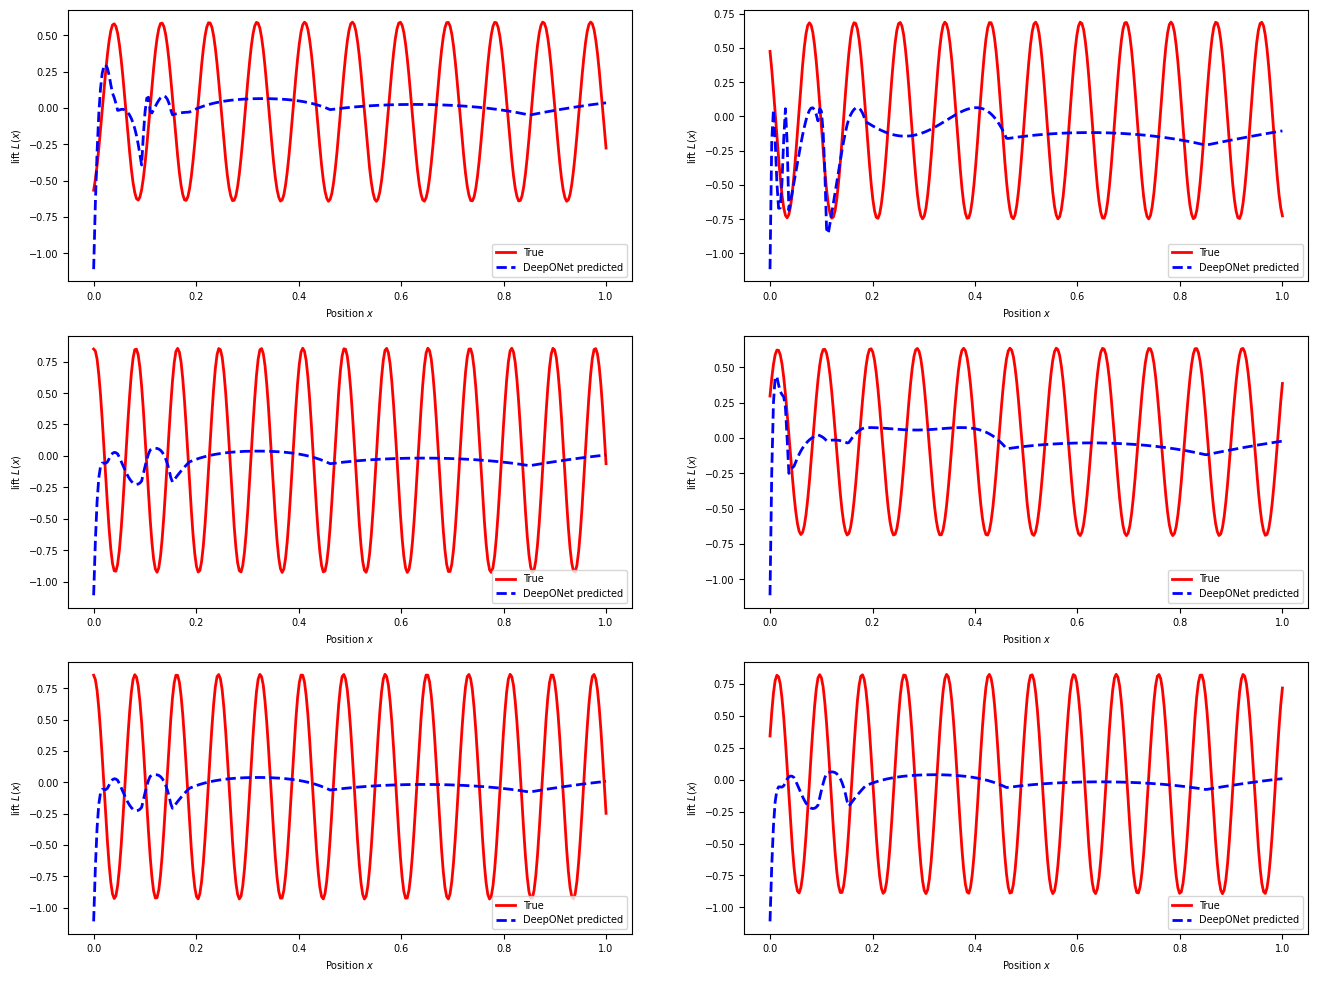

In [3]:
# %load Main.py
#!/usr/bin/env python

import argparse
import numpy as np
import torch
import utils.pytorch_utils as ptu
from models.nns import DeepONet, modified_DeepONet, Physics_DeepONet
from optim.supervisor import train, test
from utils.data_structures import DataGenerator, Dataset, \
                                  prepare_dataset, prepare_dataset_HF,prepare_DeepONet_dataset,prepare_DeepONet_dataset_HF, \
                                  scale_and_move_data_to_torch
from utils.utils import MAE_fn, MSE_fn

###################################
# Step 0:
field = args.field
method = args.method
cutting = args.cutting

   # LF-> low fidelity,
   # HF-> high fidelity
###################################

###################################
# Step 1: initialize the gpu
###################################
ptu.init_gpu(verbose=args.verbose)

###################################
# Step 2: initialize the device
###################################
np.random.seed(seed=seed)
torch.manual_seed(seed)

###################################
# Step 3: collect the LF dataset
###################################
data_pathLF ="./data/" +"Coarse_Database.npy"
Coarse_Database = np.load(data_pathLF)            # field points and measurement/sampling locations

###################################
# Step 4: prepare training and test datasets
###################################

train_data, test_data = prepare_dataset(Coarse_Database, field=field, test_size=0.1, verbose=args.verbose, rng=args.rng, cutting=cutting)
u_train, y_train, g_train = prepare_DeepONet_dataset(train_data, nLocs=args.nLocs, verbose=args.verbose)
Cylinder_datasetLF = Dataset(u_train, y_train, g_train)


###################################
# Step 5: update dataset statistics
###################################
Cylinder_datasetLF.update_statistics()

###################################
# Step 6: scale and move data to torch
###################################
U_train, Y_train, G_train = scale_and_move_data_to_torch(Cylinder_datasetLF, scale_mode=args.scale_mode, device=ptu.device, requires_grad=False)
Train_datasetLF = DataGenerator(U_train, Y_train, G_train)

###################################
# Step 7: define DeepONet LF model
###################################
branch = {}
branch["type"] = args.LF_branch_type
branch["layer_size"] = [args.nSensors] + [args.width] * args.depth + [args.nBasis]
branch["activation"] = args.activation
branch["Nmode"] = args.LF_nmode

trunk = {}
trunk["type"] = args.LF_trunk_type
trunk["layer_size"] = [1] + [args.width] * args.depth + [args.nBasis] # Create a list
trunk["activation"] = args.activation
trunk["Nmode"] = args.LF_nmode


if args.deeponet_type == "vanilla":
    A_Model = DeepONet(branch, trunk).to(ptu.device)
elif args.deeponet_type == "modified":
    A_Model = modified_DeepONet(branch, trunk).to(ptu.device)


if args.deeponet_type == "vanilla":
    B_Model = DeepONet(branch, trunk).to(ptu.device)
elif args.deeponet_type == "modified":
    B_Model = modified_DeepONet(branch, trunk).to(ptu.device)

if method== "Physics"  :    
  # ----- Model= A(u,t) * sin(B(u,t) * t) ---- #
    modelLF = Physics_DeepONet (A_Model , B_Model)
elif method== "Data" :
    modelLF = A_Model


if args.verbose:
    print(modelLF)  

###################################
# Step 8: define training parameters
###################################
train_params = {}
train_params["learning rate"] = args.learning_rate
train_params["batch size"] = args.batch_size
train_params["epochs"] = args.nEpochs
train_params["validate every"] = 1

###################################
# Step 9: define scheduler parameters
###################################
scheduler_params = {}
scheduler_params["patience"] = 100
scheduler_params["factor"] = 0.9

###################################
# Step 10: define loss function
###################################
loss_fn = MAE_fn if args.loss == "MAE" else MSE_fn

###################################
# Step 11: define logging filename
###################################
log_filenameLF = "./output/" + field + '_'+ method + "_LF_best_model.pt"

###################################
# Step 12: train the LF model
################################### 

train(modelLF,
      Train_datasetLF,
      train_params,
      scheduler_params=scheduler_params,
      loss_fn=loss_fn,
      logging_filename=log_filenameLF,
      ckpt_filename=None,
      use_ckpt=False,
      device=ptu.device,
      monitor=args.monitor,
      verbose=args.verbose,
      )

###################################
# Step 13: restore best saved LF model
###################################
ckptl = ptu.restore(log_filenameLF)
state_dict = ckptl['state_dict']
modelLF.load_state_dict(state_dict)
modelLF.to(ptu.device) 

###################################
# Step 14: test the LF model
###################################

models=[modelLF]
datasets=[Cylinder_datasetLF]
info=[field, method]

test(models,
     test_data,
     datasets,
     scale_mode=args.scale_mode,
     nLocs=300,
     device=ptu.device,
     plot_trajs=True,
     plot_idxs=[0, 1, 2, 3, 4, 5],
     verbose=args.verbose,
     info=info,
     index=1,
     )


##----------------------------------- High fidelity Part -------------------------------## 


###################################
# Step 15: collect the HF dataset
###################################
data_pathHF ="./data/" +"Fine_Database.npy"
Fine_Database = np.load(data_pathHF)            # field points and measurement/sampling locations

###################################
# Step 16: prepare training and test datasets
###################################
train_data, test_datah = prepare_dataset_HF(Fine_Database, field=field, test_size=0.12, verbose=args.verbose, rng=2*args.rng, cutting=cutting)
u_train, y_train, g_train = prepare_DeepONet_dataset(train_data, nLocs=args.nLocs, verbose=args.verbose)
Cylinder_datasetHF = Dataset(u_train, y_train, g_train)

u_train, y_train, g_train = prepare_DeepONet_dataset_HF(train_data, modelLF, Cylinder_datasetLF, scale_mode=args.scale_mode,nLocs=args.nLocs, verbose=args.verbose)
Cylinder_datasetRes = Dataset(u_train, y_train, g_train)


###################################
# Step 17: update dataset statistics
###################################
Cylinder_datasetHF.update_statistics()
Cylinder_datasetRes.update_statistics()
###################################
# Step 18: scale and move data to torch
###################################
U_train, Y_train, G_train = scale_and_move_data_to_torch(Cylinder_datasetRes, scale_mode=args.scale_mode, device=ptu.device, requires_grad=False)
Train_datasetHF = DataGenerator(U_train, Y_train, G_train)

###################################
# Step 19: define DeepONet HF model
###################################
branch = {}
branch["type"] = args.HF_branch_type
branch["layer_size"] = [args.nSensors] + [args.width]  * args.depth + [args.nBasis]
branch["activation"] = args.activation
branch["Nmode"] = args.HF_nmode

trunk = {}
trunk["type"] = args.HF_trunk_type
trunk["layer_size"] = [1] + [args.width]  * args.depth + [args.nBasis]
trunk["activation"] = args.activation
trunk["Nmode"] = args.HF_nmode


if args.deeponet_type == "vanilla":
    A_Model = DeepONet(branch, trunk).to(ptu.device)
elif args.deeponet_type == "modified":
    A_Model = modified_DeepONet(branch, trunk).to(ptu.device)


if args.deeponet_type == "vanilla":
    B_Model = DeepONet(branch, trunk).to(ptu.device)
elif args.deeponet_type == "modified":
    B_Model = modified_DeepONet(branch, trunk).to(ptu.device)


if method== "Physics"  :    
  # ----- Model= A(u,t) * sin(B(u,t) * t) ---- #
    modelHF = Physics_DeepONet (A_Model , B_Model)
elif method== "Data" :
    modelHF = A_Model


if args.verbose:
    print(modelHF)  

###################################
# Step 20: define training parameters
###################################
train_params = {}
train_params["learning rate"] = args.learning_rate
train_params["batch size"] = args.batch_size
train_params["epochs"] = args.nEpochs
train_params["validate every"] = 1

###################################
# Step 21: define scheduler parameters
###################################
scheduler_params = {}
scheduler_params["patience"] = 100
scheduler_params["factor"] = 0.9

###################################
# Step 22: define loss function
###################################
loss_fn = MAE_fn if args.loss == "MAE" else MSE_fn

###################################
# Step 23: define logging filename
###################################
log_filenameHF = "./output/"  +field+'_'+ method + "_HF_best_model.pt"

###################################
# Step 24: train the HF model
################################### 

train(modelHF,
      Train_datasetHF,
      train_params,
      scheduler_params=scheduler_params,
      loss_fn=loss_fn,
      logging_filename=log_filenameHF,
      ckpt_filename=None,
      use_ckpt=False,
      device=ptu.device,
      monitor=args.monitor,
      verbose=args.verbose,
      )
#    
###################################
# Step 25: restore best saved HF model
###################################
ckpth = ptu.restore(log_filenameHF)
state_dicth = ckpth['state_dict']
modelHF.load_state_dict(state_dicth)
modelHF.to(ptu.device) 

###################################
# Step 26: test the HF model
###################################
modelsh=[modelLF, modelHF]
datasetsh=[Cylinder_datasetLF, Cylinder_datasetRes,Cylinder_datasetHF]
info=[field, method]

test(modelsh,
     test_datah,
     datasetsh,
     scale_mode=args.scale_mode,
     nLocs=300,
     device=ptu.device,
     plot_trajs=True,
     plot_idxs=[0, 1, 2, 3, 4, 5],
     verbose=args.verbose,
     info=info,
     index=1,
     )
